In [56]:
import argparse
import torch.nn.functional as F
import torch
from torch import tensor
from network import Net1, TransferNet
import numpy as np
from utils import load_data_classification, coarsening_classification, create_distribution_tensor
import os
from tqdm import tqdm
import time
from torch_geometric.loader import DataLoader

In [62]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='Physics')
parser.add_argument('--experiment', type=str, default='fixed') #'fixed', 'random', 'few'
parser.add_argument('--runs', type=int, default=50)
parser.add_argument('--hidden', type=int, default=512)
parser.add_argument('--epochs1', type=int, default=100)
parser.add_argument('--epochs2', type=int, default=300)
parser.add_argument('--num_layers1', type=int, default=2)
parser.add_argument('--num_layers2', type=int, default=2)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--early_stopping', type=int, default=10)
parser.add_argument('--extra_node', type=bool, default=False)
parser.add_argument('--cluster_node', type=bool, default=False)
parser.add_argument('--super_graph', type=bool, default=True)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--weight_decay', type=float, default=0.0005)
parser.add_argument('--normalize_features', type=bool, default=True)
parser.add_argument('--coarsening_ratio', type=float, default=0.1)
parser.add_argument('--coarsening_method', type=str, default='variation_neighborhoods') #'variation_neighborhoods', 'variation_edges', 'variation_cliques', 'heavy_edge', 'algebraic_JC', 'affinity_GS', 'kron'
#parser.add_argument('--output_dir', type=str, required=True)

_StoreAction(option_strings=['--coarsening_method'], dest='coarsening_method', nargs=None, const=None, default='variation_neighborhoods', type=<class 'str'>, choices=None, help=None, metavar=None)

In [63]:
import sys
sys.argv = ['']

In [64]:
args = parser.parse_args()

In [66]:
args

Namespace(batch_size=128, cluster_node=False, coarsening_method='variation_neighborhoods', coarsening_ratio=0.1, dataset='Physics', early_stopping=10, epochs1=100, epochs2=300, experiment='fixed', extra_node=False, hidden=512, lr=0.01, normalize_features=True, num_layers1=2, num_layers2=2, runs=50, super_graph=True, weight_decay=0.0005)

In [67]:
args.num_features, args.num_classes, candidate, C_list, Gc_list, subgraph_list = coarsening_classification(args, 1-args.coarsening_ratio, args.coarsening_method)
print('num_features: {}, num_classes: {}'.format(args.num_features, args.num_classes))
print('Number of components: {}'.format(len(candidate)))

num_features: 8415, num_classes: 5
Number of components: 1


In [70]:
#convert to C_list[0] dence matrix
C_list[0].todense()

matrix([[0.21320072, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.20412415, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.2       , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.70710678, 0.        ,
         0.        ]])

In [7]:
coarsen_features, coarsen_train_labels, coarsen_train_mask, coarsen_val_labels, coarsen_val_mask, coarsen_edge, graphs = load_data(args, args.dataset, candidate, C_list, Gc_list, args.experiment, subgraph_list)

In [11]:
sum(g.edge_index.shape[1]//2 for g in graphs)

8905

In [9]:
graph_data = DataLoader(graphs, batch_size=len(graphs), shuffle=True)  

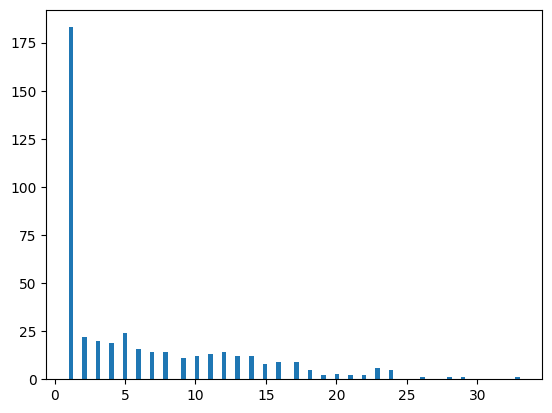

2708


In [8]:
#plot thehistogram of the number of nodes in each subgraph_list
import matplotlib.pyplot as plt
plt.hist([subgraph.num_nodes for subgraph in graph_data], bins=100)
plt.show()
print(sum([subgraph.num_nodes for subgraph in graph_data]))


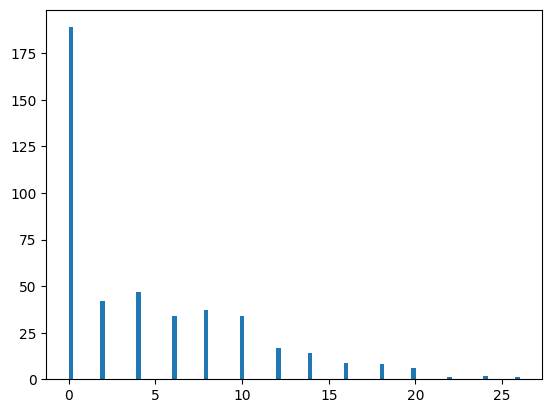

2016


In [9]:
import matplotlib.pyplot as plt
plt.hist([subgraph.num_edges for subgraph in graph_data], bins=100)
plt.show()
print(sum([subgraph.num_edges for subgraph in graph_data]))

In [28]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


A.element_size() * A.nelement()


516

In [29]:
import sys

sys.getsizeof(A.storage()), sys.getsizeof(A)

(572, 80)

In [30]:
A.storage()

 0.6271909475326538
 0.02032327651977539
 0.37129151821136475
 0.7027755975723267
 0.9352269172668457
 0.569150447845459
 0.2619343400001526
 0.6267142295837402
 0.4684200882911682
 0.8416190147399902
 0.6509881615638733
 0.04763895273208618
 0.8432051539421082
 0.5391429662704468
 0.031093955039978027
 0.06693673133850098
 0.2374688982963562
 0.2853909730911255
 0.040384650230407715
 0.7666518688201904
 0.28826904296875
 0.5399657487869263
 0.9967264533042908
 0.6551059484481812
 0.04037719964981079
 0.2977873682975769
 0.8806789517402649
 0.18844819068908691
 0.02553004026412964
 0.5311228036880493
 0.07217323780059814
 0.13390123844146729
 0.34799474477767944
 0.46495771408081055
 0.4369242787361145
 0.12264549732208252
 0.23882585763931274
 0.9977580904960632
 0.7045019865036011
 0.0919916033744812
 0.36017680168151855
 0.2639443278312683
 0.09920573234558105
 0.34226304292678833
 0.09047168493270874
 0.8658817410469055
 0.39012616872787476
 0.20726346969604492
 0.5077043175697327


In [10]:
B = torch.rand(100).to(device)
sys.getsizeof(B), sys.getsizeof(B.storage())

(80, 456)

In [17]:
from network import *
args.num_features = 1433
args.num_classes = 7
model = Net1(args)

In [27]:
A = torch.rand(129).to(device)


In [31]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=device)
print(f"gpu used {torch.cuda.max_memory_allocated(device=device)} memory")

gpu used 1024 memory


In [16]:
from torch_geometric.datasets import WikipediaNetwork

dataset = WikipediaNetwork(root='./dataset', name='chameleon', geom_gcn_preprocess=False)

/home/royshubhajit/torch_pip/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/royshubhajit/torch_pip/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


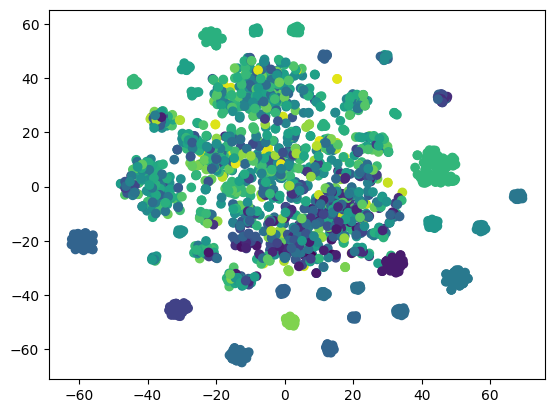

In [23]:
#tsne plot of the embeddings
import numpy
import torch
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def plot_embeddings(embeddings, labels):
    embeddings = embeddings.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    embeddings = TSNE(n_components=2).fit_transform(embeddings)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
    
    plt.show()
dataset[0].x = torch.nn.functional.normalize(dataset[0].x, p=1)
plot_embeddings(dataset[0].x, dataset[0].y)

/home/royshubhajit/torch_pip/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/royshubhajit/torch_pip/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


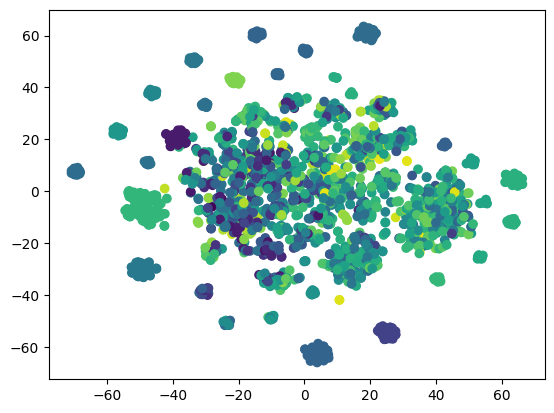

In [21]:
#tsne plot of the embeddings
import numpy
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def plot_embeddings(embeddings, labels):
    embeddings = embeddings.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    embeddings = TSNE(n_components=2).fit_transform(embeddings)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
    
    plt.show()
dataset[0].x = torch.nn.functional.normalize(dataset[0].x, p=1)
plot_embeddings(dataset[0].x, dataset[0].y)

In [44]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [51]:
k = 15
J = 1
N = torch.randperm(k)[:J]
N

tensor([8])

In [52]:
train = index_to_mask(N, k)
train

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False])

In [55]:
import numpy as np
A = np.array([1, -2, 3, 4, 5, 0, 0, 3, 1, 0, 3])
t = torch.BoolTensor(A)
t

tensor([ True,  True,  True,  True,  True, False, False,  True,  True, False,
         True])

In [1]:
from torch_geometric.datasets import TUDataset
import torch

In [43]:
dataset = TUDataset(root='./dataset', name='ENZYMES', use_node_attr=True)

In [44]:
num_classes = dataset.num_classes

In [45]:
num_classes

6

In [16]:
len(dataset)

600

In [20]:
#define a train test validation split function which splits the graph dataset data into train, test and validation sets and has a shuffle argument
def train_test_val_split(dataset, shuffle=True):
    N = len(dataset)
    if shuffle:
        idx = torch.randperm(N)
    else:
        idx = torch.arange(N)
    train = idx[:N//2]
    test = idx[N//2:3*N//4]
    val = idx[3*N//4:]
    return dataset[train], dataset[test], dataset[val]



In [21]:
train_split, test_split, val_split = train_test_val_split(dataset, shuffle=True)

In [37]:
class colater:
    def __init__(self):
        pass
    def __call__(self, data_list):
        batch_tensor = torch.tensor([])
        for i, graph in enumerate(data_list):
            batch_tensor = torch.cat((batch_tensor, torch.full((graph.x.shape[0],), i, dtype=torch.long)))
        return data_list, batch_tensor

In [38]:
from torch.utils.data import DataLoader
colater_fn = colater()
train_loader = DataLoader(train_split, batch_size=32, shuffle=True, collate_fn=colater_fn)

In [42]:
from torch_geometric.utils import unbatch, unbatch_edge_index
for graph in train_loader:
    #unbatch the graph
    graphs, batch_tensor = graph
    print(batch_tensor)


tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  ..., 31., 31., 31.])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  